In [31]:
import pandas as pd
from utils.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [32]:
df = pd.read_csv("data/training_seasonal.csv")
df = df.dropna()

In [33]:
print(df.columns)
print(df.dtypes)
print(df.describe())
print(df.shape)

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face',
       ...
       'qxajmpny', 'rcertsgn', 'tfqavkke', 'ukymxvdu', 'uqqtjvyb', 'vlluhbov',
       'xgwztkwe', 'xqwwgdyp', 'xtkaffoo', 'xzmlyyjv'],
      dtype='object', length=104)
respondent_id                  int64
h1n1_concern                 float64
h1n1_knowledge               float64
behavioral_antiviral_meds    float64
behavioral_avoidance         float64
                              ...   
vlluhbov                       int64
xgwztkwe                       int64
xqwwgdyp                       int64
xtkaffoo                       int64
xzmlyyjv                       int64
Length: 104, dtype: object
       respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
count   13104.000000  13104.000000

###  Splitting into train and test

In [34]:
target_column = "seasonal_vaccine"
y = df[target_column].values
X = df.drop([target_column,"respondent_id"], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=42,stratify=y)

### Standardizing train and test

In [35]:
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

## Trying out different models for predictions
### Linear regression

In [36]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
#
# degree=2
# model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# model.fit(X_train_standard, y_train)
# model_score = model.score(X_train,y_train)
# print(model_score)

### Random Forest # 0.79 but OVERFITTING

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

RF = RandomForestClassifier(random_state=40)
RF.fit(X_train_standard, y_train)
y_pred = RF.predict(X_test_standard)
cv_score = cross_val_score(RF,X_train, y_train,cv=100)
print("Model used is Random Forest:")
print(f"cv_score   : {np.mean(cv_score)}")
print(f"train_score: {RF.score(X_train_standard, y_train)}")
print(f"test_score : {RF.score(X_test_standard, y_test)}")
print(classification_report(y_test, y_pred))

Model used is Random Forest:
cv_score   : 0.7922326007326008
train_score: 1.0
test_score : 0.7970240366272415
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1302
           1       0.80      0.79      0.80      1319

    accuracy                           0.80      2621
   macro avg       0.80      0.80      0.80      2621
weighted avg       0.80      0.80      0.80      2621



### Neural Network

In [38]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras.metrics import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import load_model

physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("NUM GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('models/seasonal_training_{accuracy:.4f}_{val_accuracy:.4f}.h5',
                     monitor='val_accuracy', mode='max', verbose=1,
                     save_best_only=True)
lrl = ReduceLROnPlateau(patience=10,verbose=1,monitor="loss")

print(X_train_standard.shape)
model = Sequential([
    Dense(units=16, input_shape=(102,), activation="relu"),
    Dense(units=16, activation="relu"),
    Dropout(0.2),
    Dense(units=32, activation="relu"),
    Dropout(0.2),
    Dense(units=8, activation="relu"),
    Dense(units=1, activation="sigmoid")
])

learning_rate = 0.001
loss = "binary_crossentropy"
metrics = ["accuracy"]


model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=loss, metrics=metrics)
history = model.fit(X_train_standard, y_train, batch_size=100,epochs=200,
          shuffle=True, verbose=2, validation_split=0.5,
                    callbacks=[es,mc,lrl])

NUM GPUs Available:  1
(10483, 102)
Epoch 1/200
53/53 - 1s - loss: 0.6783 - accuracy: 0.5776 - val_loss: 0.6395 - val_accuracy: 0.6616

Epoch 00001: val_accuracy improved from -inf to 0.66158, saving model to models\seasonal_training_0.5776_0.6616.h5
Epoch 2/200
53/53 - 0s - loss: 0.6169 - accuracy: 0.6764 - val_loss: 0.5610 - val_accuracy: 0.7211

Epoch 00002: val_accuracy improved from 0.66158 to 0.72110, saving model to models\seasonal_training_0.6764_0.7211.h5
Epoch 3/200
53/53 - 0s - loss: 0.5502 - accuracy: 0.7319 - val_loss: 0.5201 - val_accuracy: 0.7451

Epoch 00003: val_accuracy improved from 0.72110 to 0.74514, saving model to models\seasonal_training_0.7319_0.7451.h5
Epoch 4/200
53/53 - 0s - loss: 0.5099 - accuracy: 0.7666 - val_loss: 0.5032 - val_accuracy: 0.7579

Epoch 00004: val_accuracy improved from 0.74514 to 0.75792, saving model to models\seasonal_training_0.7666_0.7579.h5
Epoch 5/200
53/53 - 0s - loss: 0.4859 - accuracy: 0.7832 - val_loss: 0.4909 - val_accuracy: 0.7

In [39]:
best_model = keep_best_saved_h5("/models","seasonal_training_",.03)
loaded_model = load_model(f"models/{best_model}")

Currently in directory:C:\Users\samyn\Desktop\GNT-Arai-31\Personal projects\drivendata_flu_shot_learning
File coming out of the function: seasonal_training_0.8046_0.7783.h5


In [40]:
print(confusion_matrix(y_test,np.round(loaded_model.predict(X_test_standard))))
print(loaded_model.evaluate(X_test_standard, y_test))

[[1031  271]
 [ 292 1027]]
82/82 [==============================] - 0s 2ms/step - loss: 0.4636 - accuracy: 0.7852
[0.46356451511383057, 0.7851964831352234]


## ???

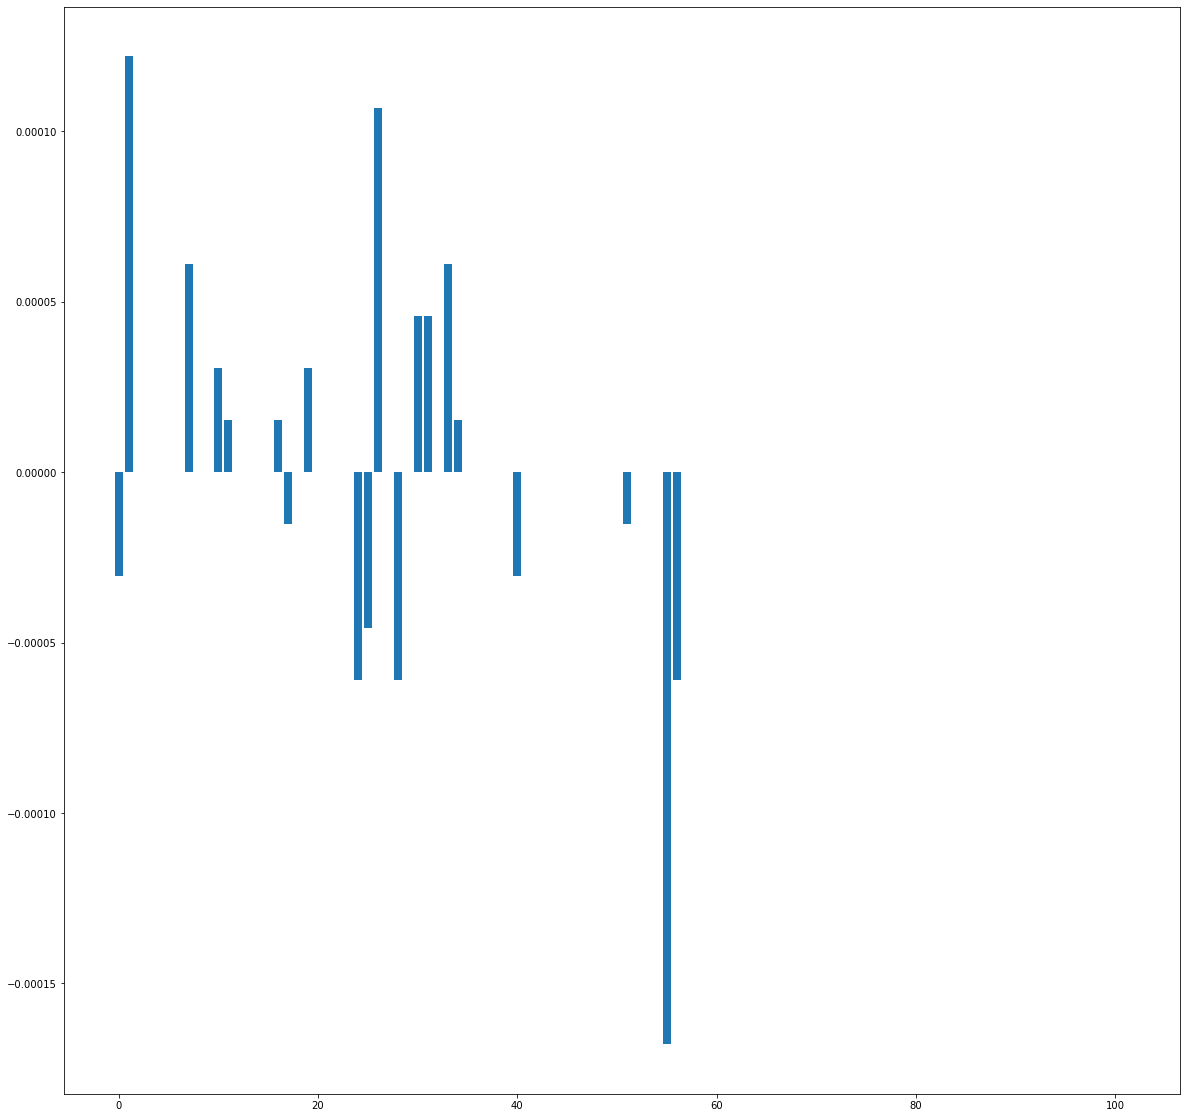

In [45]:
from sklearn.inspection import permutation_importance
plt.figure(figsize=(20,20))
results = permutation_importance(RF,X,y,scoring="accuracy")
importance = results.importances_mean
plt.bar([x for x in range(len(importance))], importance)
plt.show()